In [1]:
from sotip import *
import numpy as np
import scanpy as sc


In [2]:
adata = sc.read_h5ad('p23_20211130.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 1241 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'leiden', 'ME_heter_Cluster_uniform', 'ME_heter_Cluster_paga_guided_umap', 'leiden_EMD', 'leiden_EMD_merge'
    uns: 'Cluster_colors', 'Cluster_sizes', 'GD', 'MEidx', 'leiden', 'leiden_EMD_colors', 'leiden_EMD_merge_colors', 'leiden_EMD_merge_sizes', 'leiden_EMD_sizes', 'leiden_colors', 'merge_cls_list', 'neighbors', 'neighbors_EMD', 'paga', 'point_colors', 'umap'
    obsm: 'ME', 'X_umap', 'X_umap_EMD', 'dummy_X', 'spatial'
    obsp: 'connectivities', 'distances', 'umap_conn', 'umap_dist'

In [8]:
adata.uns['leiden_EMD_merge_colors'] = ['k','r']

In [9]:
rename_dict = {
    '13':'immune',
    '12':'tumor'
}
adata.obs['leiden_EMD_merge'] = adata.obs['leiden_EMD_merge'].cat.rename_categories(rename_dict)

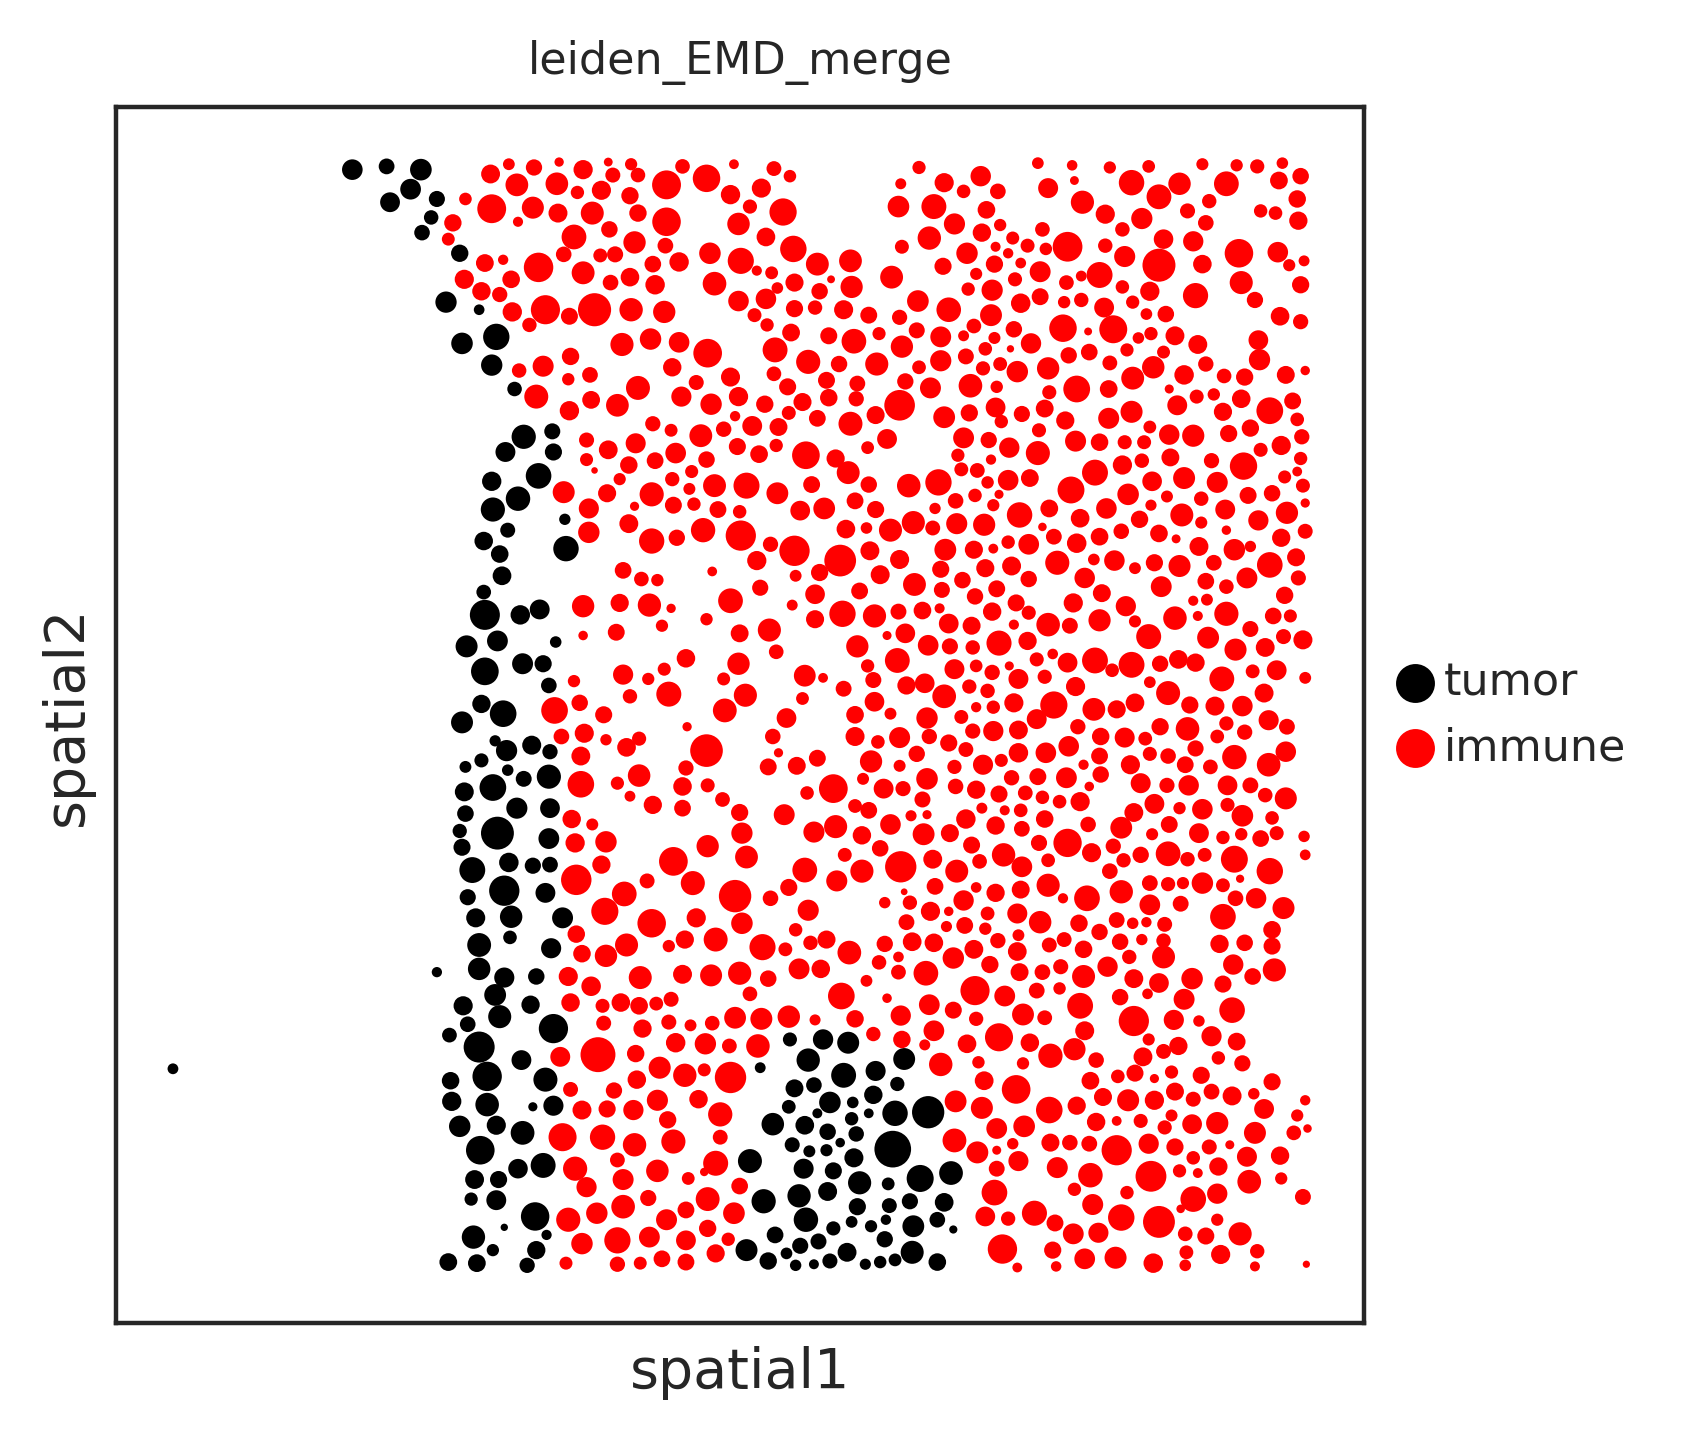

In [10]:
sc.pl.embedding(adata,basis='spatial',color=['leiden_EMD_merge'],size=adata.obs['cell_size']/10)

In [11]:
# min distance
spatial_mat = adata.obsm['spatial']
dist_mat = squareform(pdist(spatial_mat))

In [12]:
for region in adata.obs['leiden_EMD_merge'].cat.categories:
    cur_idx = np.where(adata.obs['leiden_EMD_merge']==region)[0]
    cur_dist_obs = f'min_dist_to_{region}'
    cur_min_dist = np.min(dist_mat[:,cur_idx],axis=1)
    adata.obs[cur_dist_obs] = cur_min_dist

In [13]:
adata

AnnData object with n_obs × n_vars = 1241 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'leiden', 'ME_heter_Cluster_uniform', 'ME_heter_Cluster_paga_guided_umap', 'leiden_EMD', 'leiden_EMD_merge', 'min_dist_to_tumor', 'min_dist_to_immune'
    uns: 'Cluster_colors', 'Cluster_sizes', 'GD', 'MEidx', 'leiden', 'leiden_EMD_colors', 'leiden_EMD_merge_colors', 'leiden_EMD_merge_sizes', 'leiden_EMD_sizes', 'leiden_colors', 'merge_cls_list', 'neighbors', 'neighbors_EMD', 'paga', 'point_colors', 'umap'
    obsm: 'ME', 'X_umap', 'X_umap_EMD', 'dummy_X', 'spatial'
    obsp: 'connectivities', 'distances', 'umap_conn', 'umap_dist'

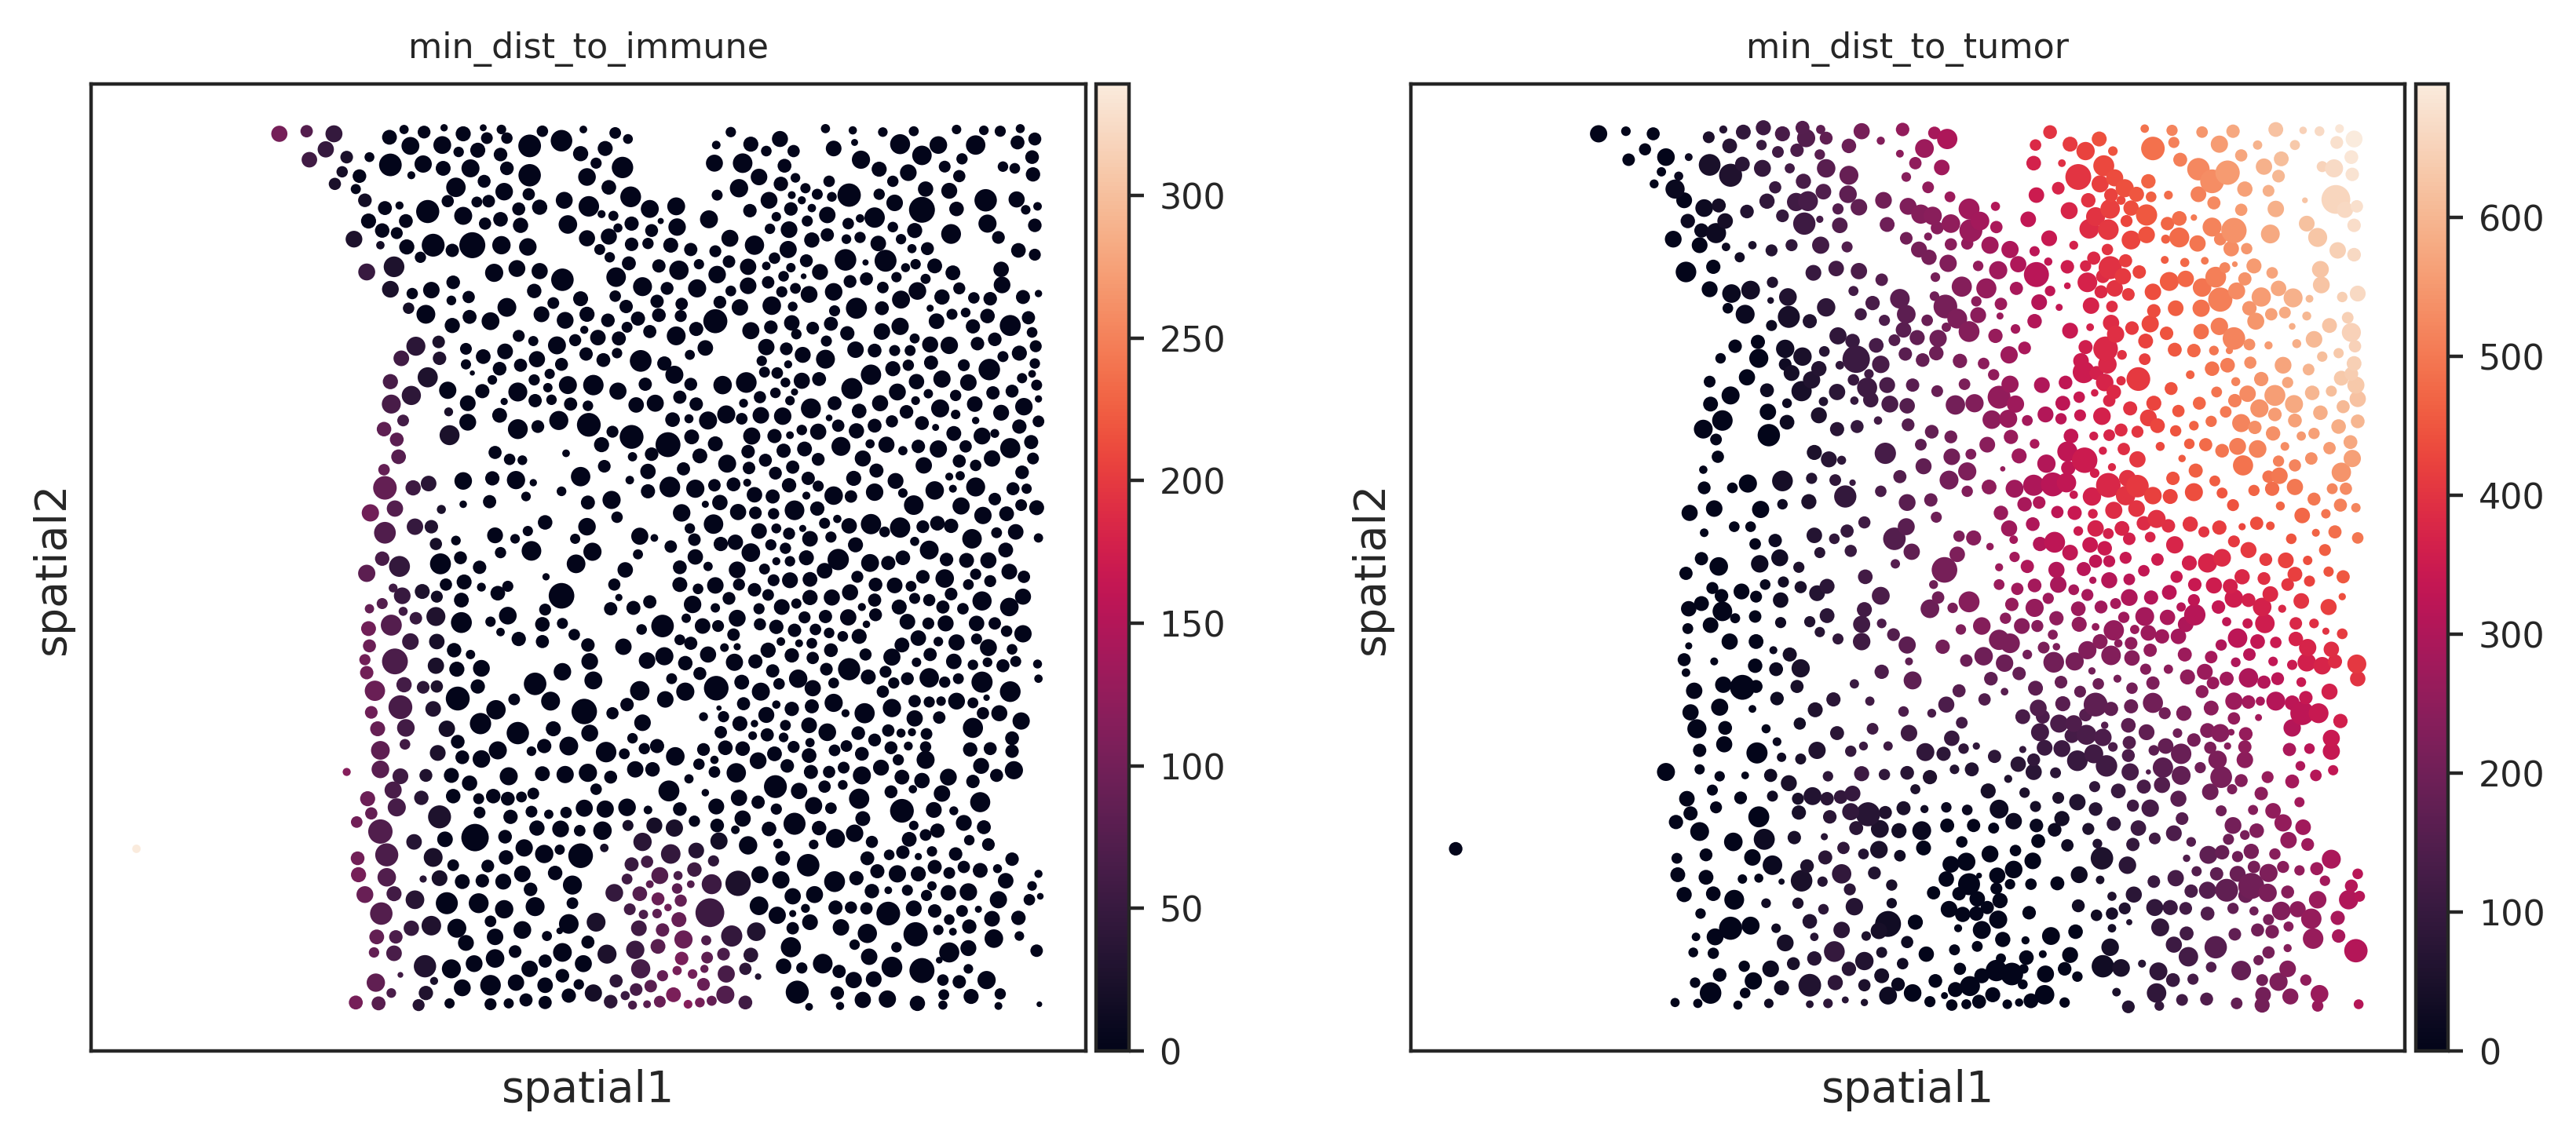

In [14]:
sc.pl.embedding(adata,basis='spatial',color=['min_dist_to_immune','min_dist_to_tumor'],size=adata.obs['cell_size']/10)

AnnData object with n_obs × n_vars = 1023 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'leiden', 'ME_heter_Cluster_uniform', 'ME_heter_Cluster_paga_guided_umap', 'Cluster_knn', 'leiden_EMD', 'leiden_EMD_merge', 'min_dist_to_immune', 'min_dist_to_tumor'
    uns: 'Cluster_colors', 'Cluster_knn_colors', 'Cluster_sizes', 'GD', 'MEidx', 'leiden', 'leiden_EMD_colors', 'leiden_EMD_merge_colors', 'leiden_EMD_merge_sizes', 'leiden_EMD_sizes', 'leiden_colors', 'merge_cls_list', 'neighbors', 'neighbors_EMD', 'paga', 'point_colors', 'umap'
    obsm: 'ME', 'X_umap', 'X_umap_EMD', 'dummy_X', 'spatial'
    obsp: 'connectivities', 'distances'

In [15]:
img_sz_um = 400
img_sz_pixel = 1024

boundary_sz_um = 20
boundary_sz_pixel = img_sz_pixel/img_sz_um*boundary_sz_um

In [16]:
boundary_array = np.array(adata.obs['leiden_EMD_merge'].copy())
min_dist_to_tumor_array = np.array(adata.obs['min_dist_to_tumor'].copy())

In [17]:
boundary_array[(boundary_array=='immune') & (min_dist_to_tumor_array<=boundary_sz_pixel)] = 'boundary'

In [18]:
adata.obs['boundary'] = boundary_array

/root/anaconda3/envs/SOTIP/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'boundary' as categorical


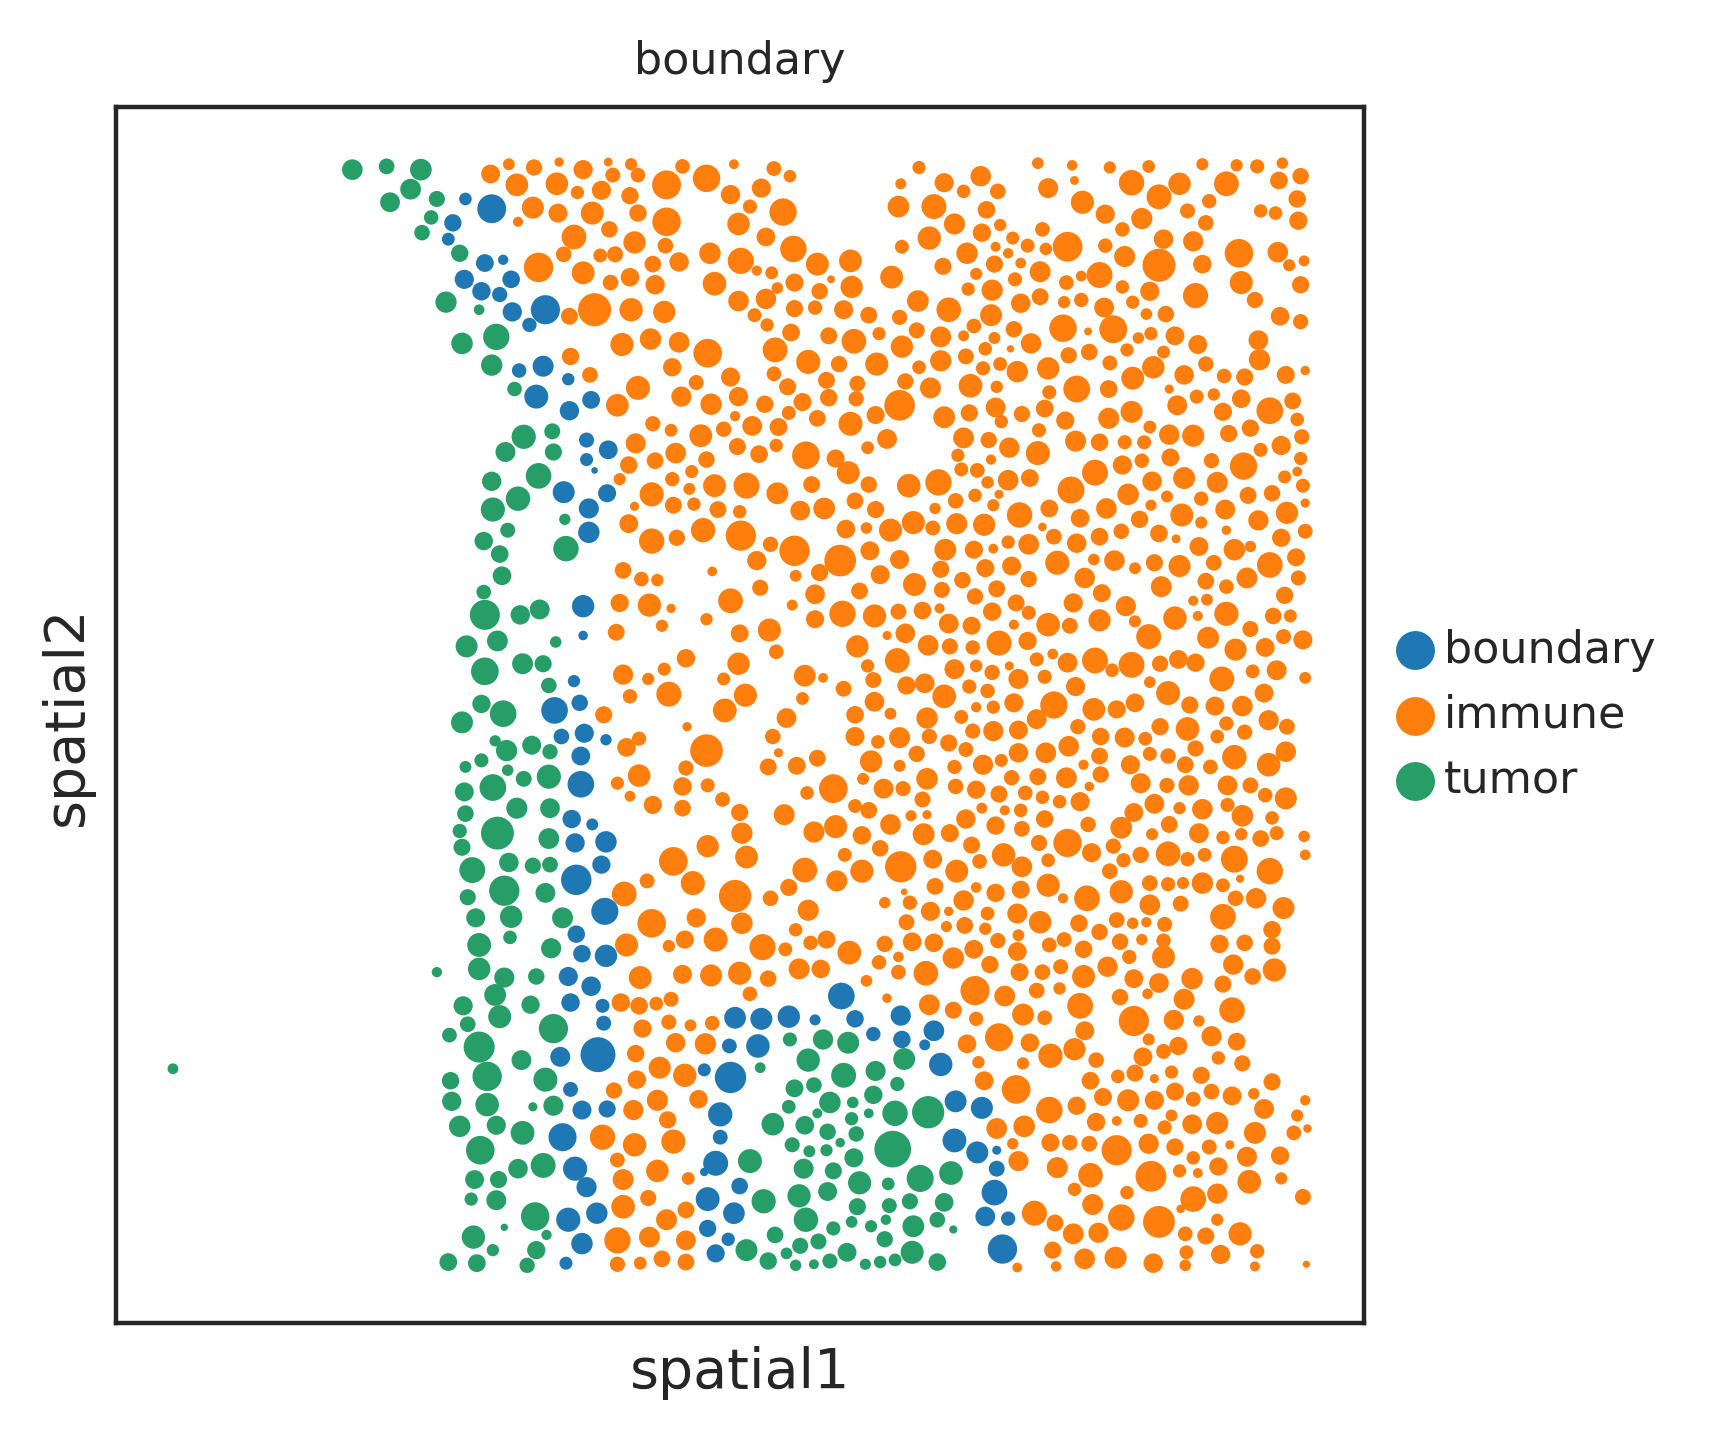

In [19]:
sc.pl.embedding(adata,basis='spatial',color=['boundary'],size=adata.obs['cell_size']/10)

In [20]:

def test_polar(adata,obs,between,protein,var):
    array_0 = np.array(adata[adata.obs[obs]==between[0],protein].X)
    array_1 = np.array(adata[adata.obs[obs]==between[1],protein].X)
    pv = ranksums(array_0,array_1,alternative='greater')[1]
    adata.var[var][np.where(adata.var_names==protein)[0]] = pv
    
    
    
    return pv

# porlar to tumor, ranksum

In [22]:
from pingouin import multicomp
obs = 'boundary'
between = ['boundary','immune']
var_name = 'sotip_polar_to_tumor'
adata.var[var_name] = np.zeros(shape=adata.shape[1])
for protein in adata.var_names:
    test_polar(adata,obs,between,protein,var_name)
pv_list = np.array(adata.var[var_name])
_,pv_adj = multicomp(pv_list,method='fdr_bh')
adata.var[f'{var_name}_bh'] = pv_adj

In [73]:
adata.var

,sotip_polar_to_tumor,sotip_polar_to_tumor_bh
H3,6.612175e-10,7.934610e-09
vimentin,8.128562e-12,2.926282e-10
SMA,1.000000e+00,1.000000e+00
CD98,2.204197e-10,3.967554e-09
NRF2p,1.504107e-05,5.760851e-05
CD4,5.568246e-04,1.002284e-03
CD14,3.489818e-04,7.390203e-04
CD45,3.156132e-03,5.164580e-03
PD1,4.708568e-01,4.985543e-01
CD31,1.801629e-06,9.265519e-06


In [24]:
gt_polarized = ['CD98','CD36','XBP1','VDAC1','G6PD','PKM2','IDH2','CS','GLUT1','NRF2p','ASCT2','SDHA','ATP5A','CD11c','CD68']

In [25]:
gt_polarized_array = np.zeros(shape=(adata.shape[1],))
adata.var['gt_polarized'] = gt_polarized_array
adata.var['gt_polarized'][adata.var_names.isin(gt_polarized)] = 1

In [26]:
adata.var

,sotip_polar_to_tumor,sotip_polar_to_tumor_bh,gt_polarized
H3,9.998996e-01,9.998996e-01,0.0
vimentin,1.958386e-12,1.175032e-11,0.0
SMA,9.684789e-09,2.681941e-08,0.0
CD98,4.103962e-19,4.924754e-18,1.0
NRF2p,4.635621e-11,1.854249e-10,1.0
CD4,8.322223e-23,1.498000e-21,0.0
CD14,9.509855e-07,2.282365e-06,0.0
CD45,1.255219e-04,1.807515e-04,0.0
PD1,3.548772e-05,5.554599e-05,0.0
CD31,2.885991e-06,5.771981e-06,0.0


In [27]:
adata.write_h5ad('sotip_polar_test_p23.h5ad')